In [11]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [16]:
#Getting the Dataset

#use your own path
data_dir = os.path.join('..', 'MadelineUdowa/flower-identification')

In [17]:
#Organizing the Dataset

def reorg_flower_data(data_dir, valid_ratio):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)

batch_size = 128
valid_ratio = 1.1
reorg_flower_data(data_dir, valid_ratio)

KeyError: 'flickr'

In [18]:
#Image Augmentation

transform_train = torchvision.transforms.Compose([
    # Randomly crop the image to obtain an image with an area of 0.08 to 1 of
    # the original area and height to width ratio between 3/4 and 4/3. Then,
    # scale the image to create a new image with a height and width of 224
    # pixels each
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                             ratio=(3.0 / 4.0, 4.0 / 3.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    # Randomly change the brightness, contrast, and saturation
    torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                       saturation=0.4),
    # Add random noise
    torchvision.transforms.ToTensor(),
    # Standardize each channel of the image
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

In [82]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    # Crop a square of 224 by 224 from the center of the image
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

In [83]:
#Reading the Dataset

train_ds, train_valid_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_test) for folder in ['valid', 'test']]

In [84]:
train_iter, train_valid_iter = [
    torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

In [85]:
#Defining the Model

def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(pretrained=True)
    # Define a new output network
    # There are 120 output categories
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256), nn.ReLU(),
                                            nn.Linear(256, 120))
    # Move model to device
    finetune_net = finetune_net.to(devices[0])
    # Freeze feature layer params
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net

In [86]:
loss = nn.CrossEntropyLoss(reduction='none')

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum = l.sum()
        n += labels.numel()
    return l_sum / n

In [87]:
#Defining The Training Functions

def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    # Only train the small custom output network
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.SGD(
        (param for param in net.parameters() if param.requires_grad), lr=lr,
        momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'valid loss'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            features, labels = features.to(devices[0]), labels.to(devices[0])
            trainer.zero_grad()
            output = net(features)
            l = loss(output, labels).sum()
            l.backward()
            trainer.step()
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss))
        scheduler.step()
    if valid_iter is not None:
        print(f'train loss {metric[0] / metric[1]:.3f}, '
              f'valid loss {valid_loss:.3f}')
    else:
        print(f'train loss {metric[0] / metric[1]:.3f}')
    print(f'{metric[1] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

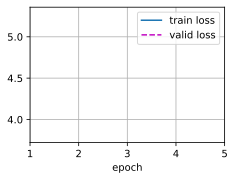

In [ ]:
#Training and Validating the Model

devices, num_epochs, lr, wd = d2l.try_all_gpus(), 5, 0.001, 1e-4
lr_period, lr_decay, net = 10, 0.1, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

In [ ]:
#Classifying the Testing Set and SUbmitting Results on Kaggle

net = get_net(devices)
net.hybridize()
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

preds = []
for data, label in test_iter:
    output_features = net.features(data.as_in_ctx(devices[0]))
    output = npx.softmax(net.output_new(output_features))
    preds.extend(output.asnumpy())
ids = sorted(
    os.listdir(os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))
with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.synsets) + '\n')
    for i, output in zip(ids, preds):
        f.write(
            i.split('.')[0] + ',' + ','.join([str(num)
                                              for num in output]) + '\n')